In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import scienceplots
import dgl

from utils.aug import load, random_aug
import sys
import time
sys.path.append('..')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
assert torch.cuda.is_available()

In [3]:
def get_timestamp():
    return time.strftime("%Y%m%d-%H%M%S")

# Classes

The classes defined here are very similar to the ones in arch, but with slight changes that make necessary its implementation here (probably could be merged, but that would only get the other code dirtier).

In [ ]:
class GCNHLayer(nn.Module):
    def __init__(self, S, in_dim, out_dim, K):
        super().__init__()

        self.S = S
        self.N = self.S.shape[0]
        self.S += torch.eye(self.N, device=self.S.device)
        self.d = self.S.sum(1)
        self.D_inv = torch.diag(1 / torch.sqrt(self.d))
        self.S = self.D_inv @ self.S @ self.D_inv

        self.K = K
        self.Spow = torch.zeros((self.K, self.N, self.N), device=self.S.device)
        self.Spow[0,:,:] = torch.eye(self.N, device=self.S.device)
        for k in range(1, self.K):
            self.Spow[k,:,:] = self.Spow[k-1,:,:] @ self.S

        self.Spow = nn.Parameter(self.Spow, requires_grad=False)

        self.S = nn.Parameter(self.S, requires_grad=False)

        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.W = nn.Parameter(torch.empty(self.K, self.in_dim, self.out_dim))
        nn.init.kaiming_uniform_(self.W.data)

    def forward(self, x):
        assert (self.N, self.in_dim) == x.shape
        out = torch.zeros((self.N, self.out_dim), device=x.device)
        for k in range(self.K):
            out += self.Spow[k,:,:] @ x @ self.W[k,:,:]
        return out

class GCNH(nn.Module):
    def __init__(self, S, in_dim, hid_dim, out_dim, K, n_layers):
        super().__init__()

        self.n_layers = n_layers
        self.convs = nn.ModuleList()

        if n_layers > 1:
            self.convs.append(GCNHLayer(S, in_dim, hid_dim, K))
            for i in range(n_layers - 2):
                self.convs.append(GCNHLayer(S, hid_dim, hid_dim, K))
            self.convs.append(GCNHLayer(S, hid_dim, out_dim, K))
        else:
            self.convs.append(GCNHLayer(S, in_dim, out_dim, K))


    def forward(self, graph, x):

        for i in range(self.n_layers - 1):
            x = torch.tanh(self.convs[i](x))
        x = self.convs[-1](x)

        return x

In [ ]:
class GCN(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, n_layers):
        super().__init__()

        self.n_layers = n_layers
        self.convs = nn.ModuleList()

        if n_layers > 1:
            self.convs.append(dgl.nn.GraphConv(in_dim, hid_dim, norm='both'))
            for i in range(n_layers - 2):
                self.convs.append(dgl.nn.GraphConv(hid_dim, hid_dim, norm='both'))
            self.convs.append(dgl.nn.GraphConv(hid_dim, out_dim, norm='both'))
        else:
            self.convs.append(dgl.nn.GraphConv(in_dim, out_dim, norm='both'))

    def forward(self, graph, x):

        for i in range(self.n_layers - 1):
            x = F.relu(self.convs[i](graph, x))
        x = self.convs[-1](graph, x)

        return x

class MLP(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, n_layers):
        super().__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.n_layers = n_layers

        self.layers = nn.ModuleList()

        self.layers.append(nn.Linear(in_dim, hid_dim))

        if n_layers > 1:
            self.layers.append(nn.Linear(in_dim, hid_dim))
            for i in range(n_layers - 2):
                self.layers.append(nn.Linear(hid_dim, hid_dim))
            self.layers.append(nn.Linear(hid_dim, out_dim))
        else:
            self.layers.append(nn.Linear(in_dim, out_dim))

    def forward(self, graph, x): # Graph kept for compatibility with GCN

        for i in range(self.n_layers - 1):
            x = F.relu(self.layers[i](x))
        x = self.layers[-1](x)

        return x

In [ ]:
class GCN(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, n_layers):
        super().__init__()

        self.n_layers = n_layers
        self.convs = nn.ModuleList()

        self.convs.append(dgl.nn.GraphConv(in_dim, hid_dim, norm='both'))

        if n_layers > 1:
            for i in range(n_layers - 2):
                self.convs.append(dgl.nn.GraphConv(hid_dim, hid_dim, norm='both'))
            self.convs.append(dgl.nn.GraphConv(hid_dim, out_dim, norm='both'))

    def forward(self, graph, x):

        for i in range(self.n_layers - 1):
            x = F.relu(self.convs[i](graph, x))
        x = self.convs[-1](graph, x)

        return x
    
class MLP(nn.Module):
    def __init__(self, nfeat, nhid, nclass, _, use_bn=True):
        super(MLP, self).__init__()

        self.layer1 = nn.Linear(nfeat, nhid, bias=True)
        self.layer2 = nn.Linear(nhid, nclass, bias=True)

        self.bn = nn.BatchNorm1d(nhid)
        self.use_bn = use_bn
        self.act_fn = nn.ReLU()

    def forward(self, _, x):
        x = self.layer1(x)
        if self.use_bn:
            x = self.bn(x)

        x = self.act_fn(x)
        x = self.layer2(x)

        return x

In [ ]:
class IOArch(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, Nx, Ny, n_layers, method, transform_y=False):
        super().__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.n_layers = n_layers
        self.Nx = Nx
        self.Ny = Ny
        assert method in ["fill", "linear", "transpose", "nothing"], "Not a valid method chosen"
        self.method = method
        
        if self.method == "transpose":
            self.X_out_dim = self.Ny
            self.Y_out_dim = self.Nx
        else:
            self.X_out_dim = self.hid_dim
            self.Y_out_dim = self.hid_dim

        if self.method == "linear":
            self.linear_transform = nn.Parameter(torch.empty((self.Ny, self.Nx)))
            torch.nn.init.kaiming_uniform_(self.linear_transform.data)

    def transform(self, Z):
        if self.method == "fill":
            Zy = torch.ones((self.Ny, Z.shape[1]), device=Z.device)
            Zy[self.idxs] = Z
        elif self.method == "linear":
            Zy = self.linear_transform @ Z
        elif self.method == "transpose":
            Zy = Z.T
        elif self.method == "nothing":
            Zy = Z

        return Zy

    def forward(self, graph1, graph2, feat_x, feat_y):
        assert feat_x.shape[0] == self.Nx
        Zx = self.arch_X(graph1, feat_x)
        Zx = self.transform(Zx)
        Zy = self.arch_Y(graph2, feat_y)

        assert Zx.shape == Zy.shape

        Zx_norm = (Zx - Zx.mean(0)) / Zx.std(0)
        Zy_norm = (Zy - Zy.mean(0)) / Zy.std(0)

        return Zx_norm, Zy_norm
    
    def get_embeddings(self, graph, feat):
        Zx = self.arch_X(graph, feat)
        return Zx.detach()

class IOGCN(IOArch):
    def __init__(self, in_dim, hid_dim, out_dim, Nx, Ny, n_layers, method, transform_y=False):
        super().__init__(in_dim, hid_dim, out_dim, Nx, Ny, n_layers, method, transform_y)

        self.arch_X = GCN(in_dim, hid_dim, self.X_out_dim, n_layers)
        self.arch_Y = GCN(in_dim, hid_dim, self.Y_out_dim, n_layers)

class IOGCNH(IOArch):
    def __init__(self, Sx, Sy, in_dim, hid_dim, out_dim, Nx, Ny, n_layers, K, method, transform_y=False):
        super().__init__(in_dim, hid_dim, out_dim, Nx, Ny, n_layers, method, transform_y)

        self.arch_X = GCNH(Sx, in_dim, hid_dim, self.X_out_dim, K, n_layers)
        self.arch_Y = GCNH(Sy, in_dim, hid_dim, self.Y_out_dim, K, n_layers)

class IOMLP(IOArch):
    def __init__(self, in_dim, hid_dim, out_dim, Nx, Ny, n_layers, method, transform_y=False):
        super().__init__(in_dim, hid_dim, out_dim, Nx, Ny, n_layers, method, transform_y)

        self.arch_X = MLP(in_dim, hid_dim, self.X_out_dim, n_layers)
        self.arch_Y = MLP(in_dim, hid_dim, self.Y_out_dim, n_layers)

In [4]:
class CCA_SSG(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, n_layers, use_mlp = False):
        super().__init__()
        if not use_mlp:
            self.backbone = GCN(in_dim, hid_dim, out_dim, n_layers)
        else:
            self.backbone = MLP(in_dim, hid_dim, out_dim)

    def get_embeddings(self, graph, feat):
        out = self.backbone(graph, feat)
        return out.detach()

    def forward(self, graph1, graph2, feat1, feat2):
        h1 = self.backbone(graph1, feat1)
        h2 = self.backbone(graph2, feat2)

        z1 = (h1 - h1.mean(0)) / h1.std(0)
        z2 = (h2 - h2.mean(0)) / h2.std(0)

        return z1, z2

In [5]:
class LogReg(nn.Module):
    def __init__(self, hid_dim, out_dim):
        super(LogReg, self).__init__()
        self.fc = nn.Linear(hid_dim, out_dim)

    def forward(self, x):
        ret = self.fc(x)
        return ret

# Data

In [6]:
graph, feat, labels, num_class, train_idx, val_idx, test_idx = load("cora")
in_dim = feat.shape[1]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [7]:
lr = 1e-3 # For CCA-SSG is 1e-3
lr_logreg = 1e-2
wd = 0
wd_logreg = 1e-4
lambd = 1e-3
n_epochs = 100

n_layers = 2
hid_dim = 512
out_dim = 512
eval_freq = 20
eval_freq_logreg = 100
method = "linear" # linear, fill

N = Nx = graph.number_of_nodes()
Ny = 1500
Ny = train_idx.shape[0] + val_idx.shape[0] + test_idx.shape[0]

g = graph.to(device)
feat = feat.to(device)
labels = labels.to(device)

In [8]:
def neigh_sampling(g, N_nodes):
    finished = False
    while not finished:
        init_node = np.random.randint(g.number_of_nodes())

        list_nodes = [init_node]

        while True:
            old_len = len(list_nodes)
            new_nodes = list_nodes.copy()
            new_nodes.extend([x.item() for x in g.in_edges(list_nodes)[0]])
            list_nodes = list(set(new_nodes))
            new_len = len(list_nodes)
            if old_len == new_len:
                # Prevent infinite loop
                finished = False
                break
            if len(list_nodes) > N_nodes:
                list_nodes = list_nodes[:N_nodes]
                finished = True
                break
    return list_nodes

In [9]:
def generate_subgraph(g, feat, N_nodes, return_idxs=False):
    idxs = neigh_sampling(g, N_nodes)
    idxs = torch.concatenate([train_idx, val_idx, test_idx])

    subg = graph.subgraph(idxs).add_self_loop().to(device)

    x = feat[idxs].to(device)

    if return_idxs:
        return subg, x, idxs
    else:
        return subg, x

In [10]:
def test(model, gpert, subgraph, feat, y, labels, lr, model_name, verbose=True):

    N = feat.shape[0]

    if model_name == "linear_cca":
        assert feat.shape == y.shape
        
        cov_xx = feat @ feat.T / N
        cov_yy = y @ y.T / N
        cov_xy = feat @ y.T / N

        sqrt_inv_xx = linalg.inv(linalg.sqrtm(cov_xx))
        sqrt_inv_yy = linalg.inv(linalg.sqrtm(cov_yy))

        T = sqrt_inv_xx @ cov_xy @ sqrt_inv_yy
        U, D, V = linalg.svd(T, full_matrices=False)

        u_opt = sqrt_inv_xx @ U[:,:hid_dim]
        v_opt = sqrt_inv_yy @ V.T[:,:hid_dim]

        embeds = torch.tensor(v_opt @ y, device=device)

        train_embs = embeds[train_idx]
        val_embs = embeds[val_idx]
        test_embs = embeds[test_idx]
    else:
        
        opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

        losses = np.zeros(n_epochs)
        for i in range(n_epochs):
            model.train()
            opt.zero_grad()

            if model_name == "CCA-SSG":
                gx, x = random_aug(gpert, feat, .2, .2)
                gy, y = random_aug(gpert, feat, .2, .2)

                gx = gx.add_self_loop()
                gy = gy.add_self_loop()

                gx = gx.to(device)
                gy = gy.to(device)

                x = x.to(device)
                y = y.to(device)
            else:
                gx = gpert.clone()
                gy = subgraph.clone()

                gx = gx.add_self_loop()
                gy = gy.add_self_loop()

                gx = gx.to(device)
                gy = gy.to(device)

                x = feat.clone().to(device)
                y = y.to(device)

            Zx, Zy = model(gx, gy, x, y)
          
            c = Zx.T @ Zy
            c1 = Zx.T @ Zx
            c2 = Zy.T @ Zy

            c = c / N
            c1 = c1 / Zx.shape[0]
            c2 = c2 / Zy.shape[0]

            loss_inv = -torch.diagonal(c).sum()
            iden = torch.eye(c.shape[0], device=c.device)
            loss_dec1 = (iden - c1).pow(2).sum()
            loss_dec2 = (iden - c2).pow(2).sum()

            loss = loss_inv + lambd * (loss_dec1 + loss_dec2)

            loss.backward()
            opt.step()

            losses[i] = loss.item()

            if (i == 0 or (i+1) % eval_freq == 0) and verbose:
                print(f"Epoch {i+1}/{n_epochs} - Loss: {losses[i]}", flush=True)

        if model_name == "CCA-SSG":
            gpert = gpert.add_self_loop().to(device)
            embeds = model.get_embeddings(gpert, feat)

            train_embs = embeds[train_idx]
            val_embs = embeds[val_idx]
            test_embs = embeds[test_idx]

        else:
            subgraph = subgraph.add_self_loop().to(device)
            embeds = model.arch_Y(subgraph, y).detach()

            train_embs = embeds[:len(train_idx)]
            val_embs = embeds[len(train_idx):len(train_idx)+len(val_idx)]
            test_embs = embeds[len(train_idx)+len(val_idx):]

    label = labels.to(device)

    train_labels = label[train_idx]
    val_labels = label[val_idx]
    test_labels = label[test_idx]

    ''' Linear Evaluation '''
    logreg = LogReg(train_embs.shape[1], num_class)
    opt2 = torch.optim.Adam(logreg.parameters(), lr=lr_logreg, weight_decay=wd_logreg)

    logreg = logreg.to(device)
    loss_fn = nn.CrossEntropyLoss()

    best_val_acc = 0
    eval_acc = 0

    for epoch in range(2000):
        logreg.train()
        opt2.zero_grad()
        logits = logreg(train_embs)
        preds = torch.argmax(logits, dim=1)
        train_acc = torch.sum(preds == train_labels).float() / train_labels.shape[0]
        loss = loss_fn(logits, train_labels)
        loss.backward()
        opt2.step()

        logreg.eval()
        with torch.no_grad():
            val_logits = logreg(val_embs)
            test_logits = logreg(test_embs)

            val_preds = torch.argmax(val_logits, dim=1)
            test_preds = torch.argmax(test_logits, dim=1)

            val_acc = torch.sum(val_preds == val_labels).float() / val_labels.shape[0]
            test_acc = torch.sum(test_preds == test_labels).float() / test_labels.shape[0]

            if val_acc >= best_val_acc:
                best_val_acc = val_acc
                if test_acc > eval_acc:
                    eval_acc = test_acc

            if epoch % eval_freq_logreg == 0 and verbose:
                print('Epoch:{}, train_acc:{:.4f}, val_acc:{:4f}, test_acc:{:4f}'.format(epoch, train_acc, val_acc, test_acc))
    if verbose:
        print('Linear evaluation accuracy:{:.4f}'.format(eval_acc))

    return losses, eval_acc.item()

In [11]:
# Creating the graphs available
gpert, featpert = random_aug(graph, feat, 0.7, 0.7)
subgraph, y, idxs_y = generate_subgraph(graph, feat, Ny, return_idxs=True)

In [12]:
yfeat_lcca = torch.zeros(featpert.shape, device=y.device)
yfeat_lcca[idxs_y] = y

In [13]:
#losses_lcca, eval_acc_lcca = test(None, gpert, subgraph, featpert.cpu().numpy(), yfeat_lcca.cpu().numpy(), labels, lr, "linear_cca")

In [14]:
#%%timeit
iogcn = IOGCN(in_dim, hid_dim, out_dim, Nx, Ny, n_layers, method=method, transform_y=False).to(device)
#only_gcn = GCN(in_dim, hid_dim, out_dim, 2*n_layers).to(device)

losses_iogcn, eval_acc_iogcn = test(iogcn, gpert, subgraph, featpert, y, labels, lr, "iogcn")
#acc_train_only_gcn, acc_val_only_gcn, acc_test_only_gcn = test(only_gcn, x_gcn, "gcn")

TypeError: __init__() got an unexpected keyword argument 'transform_y'

In [19]:
#%%timeit
ccassg = CCA_SSG(in_dim, hid_dim, out_dim, n_layers).to(device)

losses_ccassg, eval_acc_ccassg = test(ccassg, gpert, subgraph, featpert, y, labels, lr, "CCA-SSG")

Epoch 1/100 - Loss: -330.6357421875
Epoch 20/100 - Loss: -396.115478515625
Epoch 40/100 - Loss: -402.95391845703125
Epoch 60/100 - Loss: -414.54705810546875
Epoch 80/100 - Loss: -427.7635498046875
Epoch 100/100 - Loss: -425.94842529296875
Epoch:0, train_acc:0.1429, val_acc:0.308000, test_acc:0.334000
Epoch:100, train_acc:0.7357, val_acc:0.476000, test_acc:0.496000
Epoch:200, train_acc:0.7429, val_acc:0.492000, test_acc:0.501000
Epoch:300, train_acc:0.7571, val_acc:0.490000, test_acc:0.500000
Epoch:400, train_acc:0.7571, val_acc:0.488000, test_acc:0.502000
Epoch:500, train_acc:0.7571, val_acc:0.488000, test_acc:0.502000
Epoch:600, train_acc:0.7714, val_acc:0.488000, test_acc:0.502000
Epoch:700, train_acc:0.7714, val_acc:0.488000, test_acc:0.504000
Epoch:800, train_acc:0.7786, val_acc:0.488000, test_acc:0.504000
Epoch:900, train_acc:0.7786, val_acc:0.488000, test_acc:0.503000
Epoch:1000, train_acc:0.7786, val_acc:0.488000, test_acc:0.503000
Epoch:1100, train_acc:0.7786, val_acc:0.488000,

In [20]:
iomlp = IOMLP(in_dim, hid_dim, out_dim, Nx, Ny, n_layers, method=method, transform_y=False).to(device)
loss_iomlp, eval_acc_iomlp = test(iomlp, gpert, subgraph, featpert, y, labels, lr, "IOMLP")

Epoch 1/100 - Loss: 19.890155792236328
Epoch 20/100 - Loss: -281.14727783203125
Epoch 40/100 - Loss: -297.108154296875
Epoch 60/100 - Loss: -301.16925048828125
Epoch 80/100 - Loss: -303.0064392089844
Epoch 100/100 - Loss: -304.13543701171875
Epoch:0, train_acc:0.1429, val_acc:0.174000, test_acc:0.205000
Epoch:100, train_acc:1.0000, val_acc:0.362000, test_acc:0.349000
Epoch:200, train_acc:1.0000, val_acc:0.356000, test_acc:0.351000
Epoch:300, train_acc:1.0000, val_acc:0.356000, test_acc:0.349000
Epoch:400, train_acc:1.0000, val_acc:0.358000, test_acc:0.352000
Epoch:500, train_acc:1.0000, val_acc:0.360000, test_acc:0.354000
Epoch:600, train_acc:1.0000, val_acc:0.362000, test_acc:0.352000
Epoch:700, train_acc:1.0000, val_acc:0.362000, test_acc:0.353000
Epoch:800, train_acc:1.0000, val_acc:0.360000, test_acc:0.353000
Epoch:900, train_acc:1.0000, val_acc:0.362000, test_acc:0.354000
Epoch:1000, train_acc:1.0000, val_acc:0.364000, test_acc:0.355000
Epoch:1100, train_acc:1.0000, val_acc:0.3620

# More Exhaustive tests

In [5]:
EXPS = [
    {
        'model': 'IOGCN',
        'method': 'linear',
        'label': 'IOGCN',
        'color': 'b'
    },
    {
        'model': 'IOMLP',
        'method': 'linear',
        'label': 'IOMLP',
        'color': 'g'
    },
    {
        'model': 'CCA-SSG',
        'method': None,
        'label': 'CCA-SSG',
        'color': 'r'
    }
]

In [24]:
n_graphs = 25
eval_accs = np.zeros((len(EXPS), n_graphs))
print(f"GRAPH (of {n_graphs}) - ", end="")
for g in range(n_graphs):
    print(f"{g+1} ", end="", flush=True)

    # Creating the graphs available
    gpert, featpert = random_aug(graph, feat, 0.9, 0.9)
    subgraph, y = generate_subgraph(graph, feat, Ny)
    
    for i, exp in enumerate(EXPS):
        if exp['model'] == "CCA-SSG":
            model = CCA_SSG(in_dim, hid_dim, out_dim, n_layers)
        else:
            model = eval(exp['model'])(in_dim, hid_dim, out_dim, Nx, Ny, n_layers, method=exp['method'], transform_y=False)

        model = model.to(device)

        _, eval_accs[i,g] = test(model, gpert, subgraph, featpert, y, labels, lr, exp['model'], verbose=False)
print("- DONE")

GRAPH (of 10) - 1 2 3 4 5 6 7 8 9 10 - DONE


{'whiskers': [<matplotlib.lines.Line2D at 0x7f1a3dd23c10>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1a3dd43190>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f1a3dd23970>,
 'medians': [<matplotlib.lines.Line2D at 0x7f1a3dd436d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f1a3dd43970>,
 'means': []}

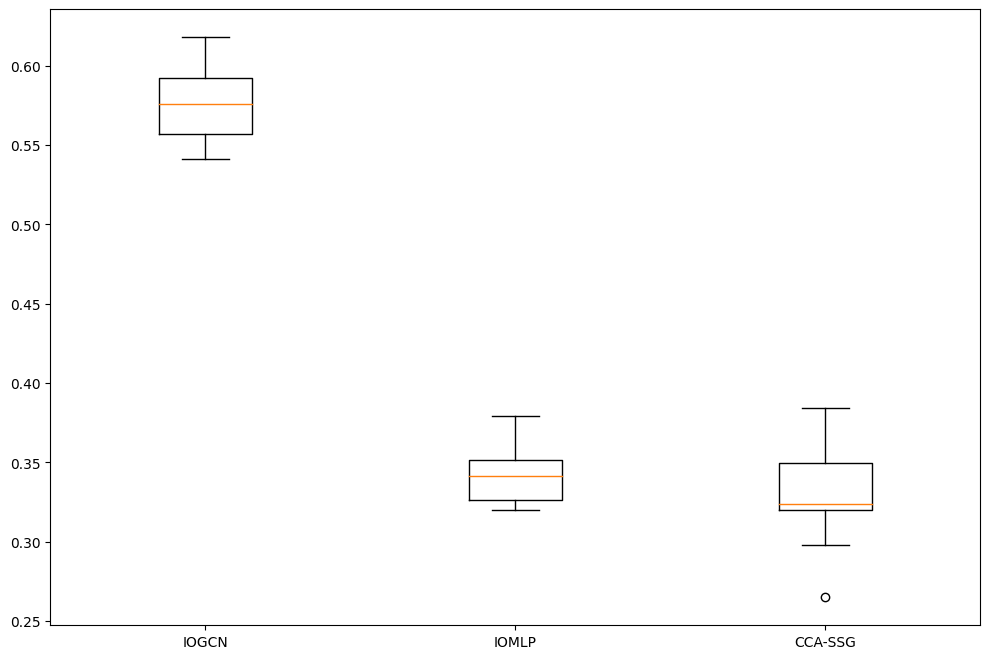

In [25]:
plt.figure(figsize=(12,8))

plt.boxplot(eval_accs.T, labels=[exp['label'] for exp in EXPS])

In [6]:
n_graphs = 25

#perts = [0., 0.2, 0.4, 0.6, 0.8, 0.9, 0.95]
perts = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]

datasets = ['cora', 'citeseer']

eval_accs = np.zeros((len(datasets), len(perts), len(EXPS), n_graphs))

for d, dataset_name in enumerate(datasets):
    print(f"Starting Dataset {dataset_name} - ")

    graph, feat, labels, num_class, train_idx, val_idx, test_idx = load(dataset_name)
    in_dim = feat.shape[1]
    N = Nx = graph.number_of_nodes()
    Ny = train_idx.shape[0] + val_idx.shape[0] + test_idx.shape[0]

    feat = feat.to(device)
    labels = labels.to(device)

    for i, p in enumerate(perts):
        print(f"Pert {p} ({i+1}/{len(perts)}) - ", end="")

        for g in range(n_graphs):
            print(f"{g+1} ", end="", flush=True)

            # Creating the graphs available
            gpert, featpert = random_aug(graph, feat, p, p)
            subgraph, y = generate_subgraph(graph, feat, Ny)
            
            for j, exp in enumerate(EXPS):
                if exp['model'] == "CCA-SSG":
                    model = CCA_SSG(in_dim, hid_dim, out_dim, n_layers)
                else:
                    model = eval(exp['model'])(in_dim, hid_dim, out_dim, Nx, Ny, n_layers, method=exp['method'], transform_y=False)

                model = model.to(device)

                _, eval_accs[d,i,j,g] = test(model, gpert, subgraph, featpert, y, labels, lr, exp['model'], verbose=False)
        print("- DONE")

save = True
if save:
    np.save("eval_accs", eval_accs)

Starting Dataset cora - 
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


NameError: name 'device' is not defined

In [9]:
load = False
if load:
    eval_accs = np.load("eval_accs.npy")

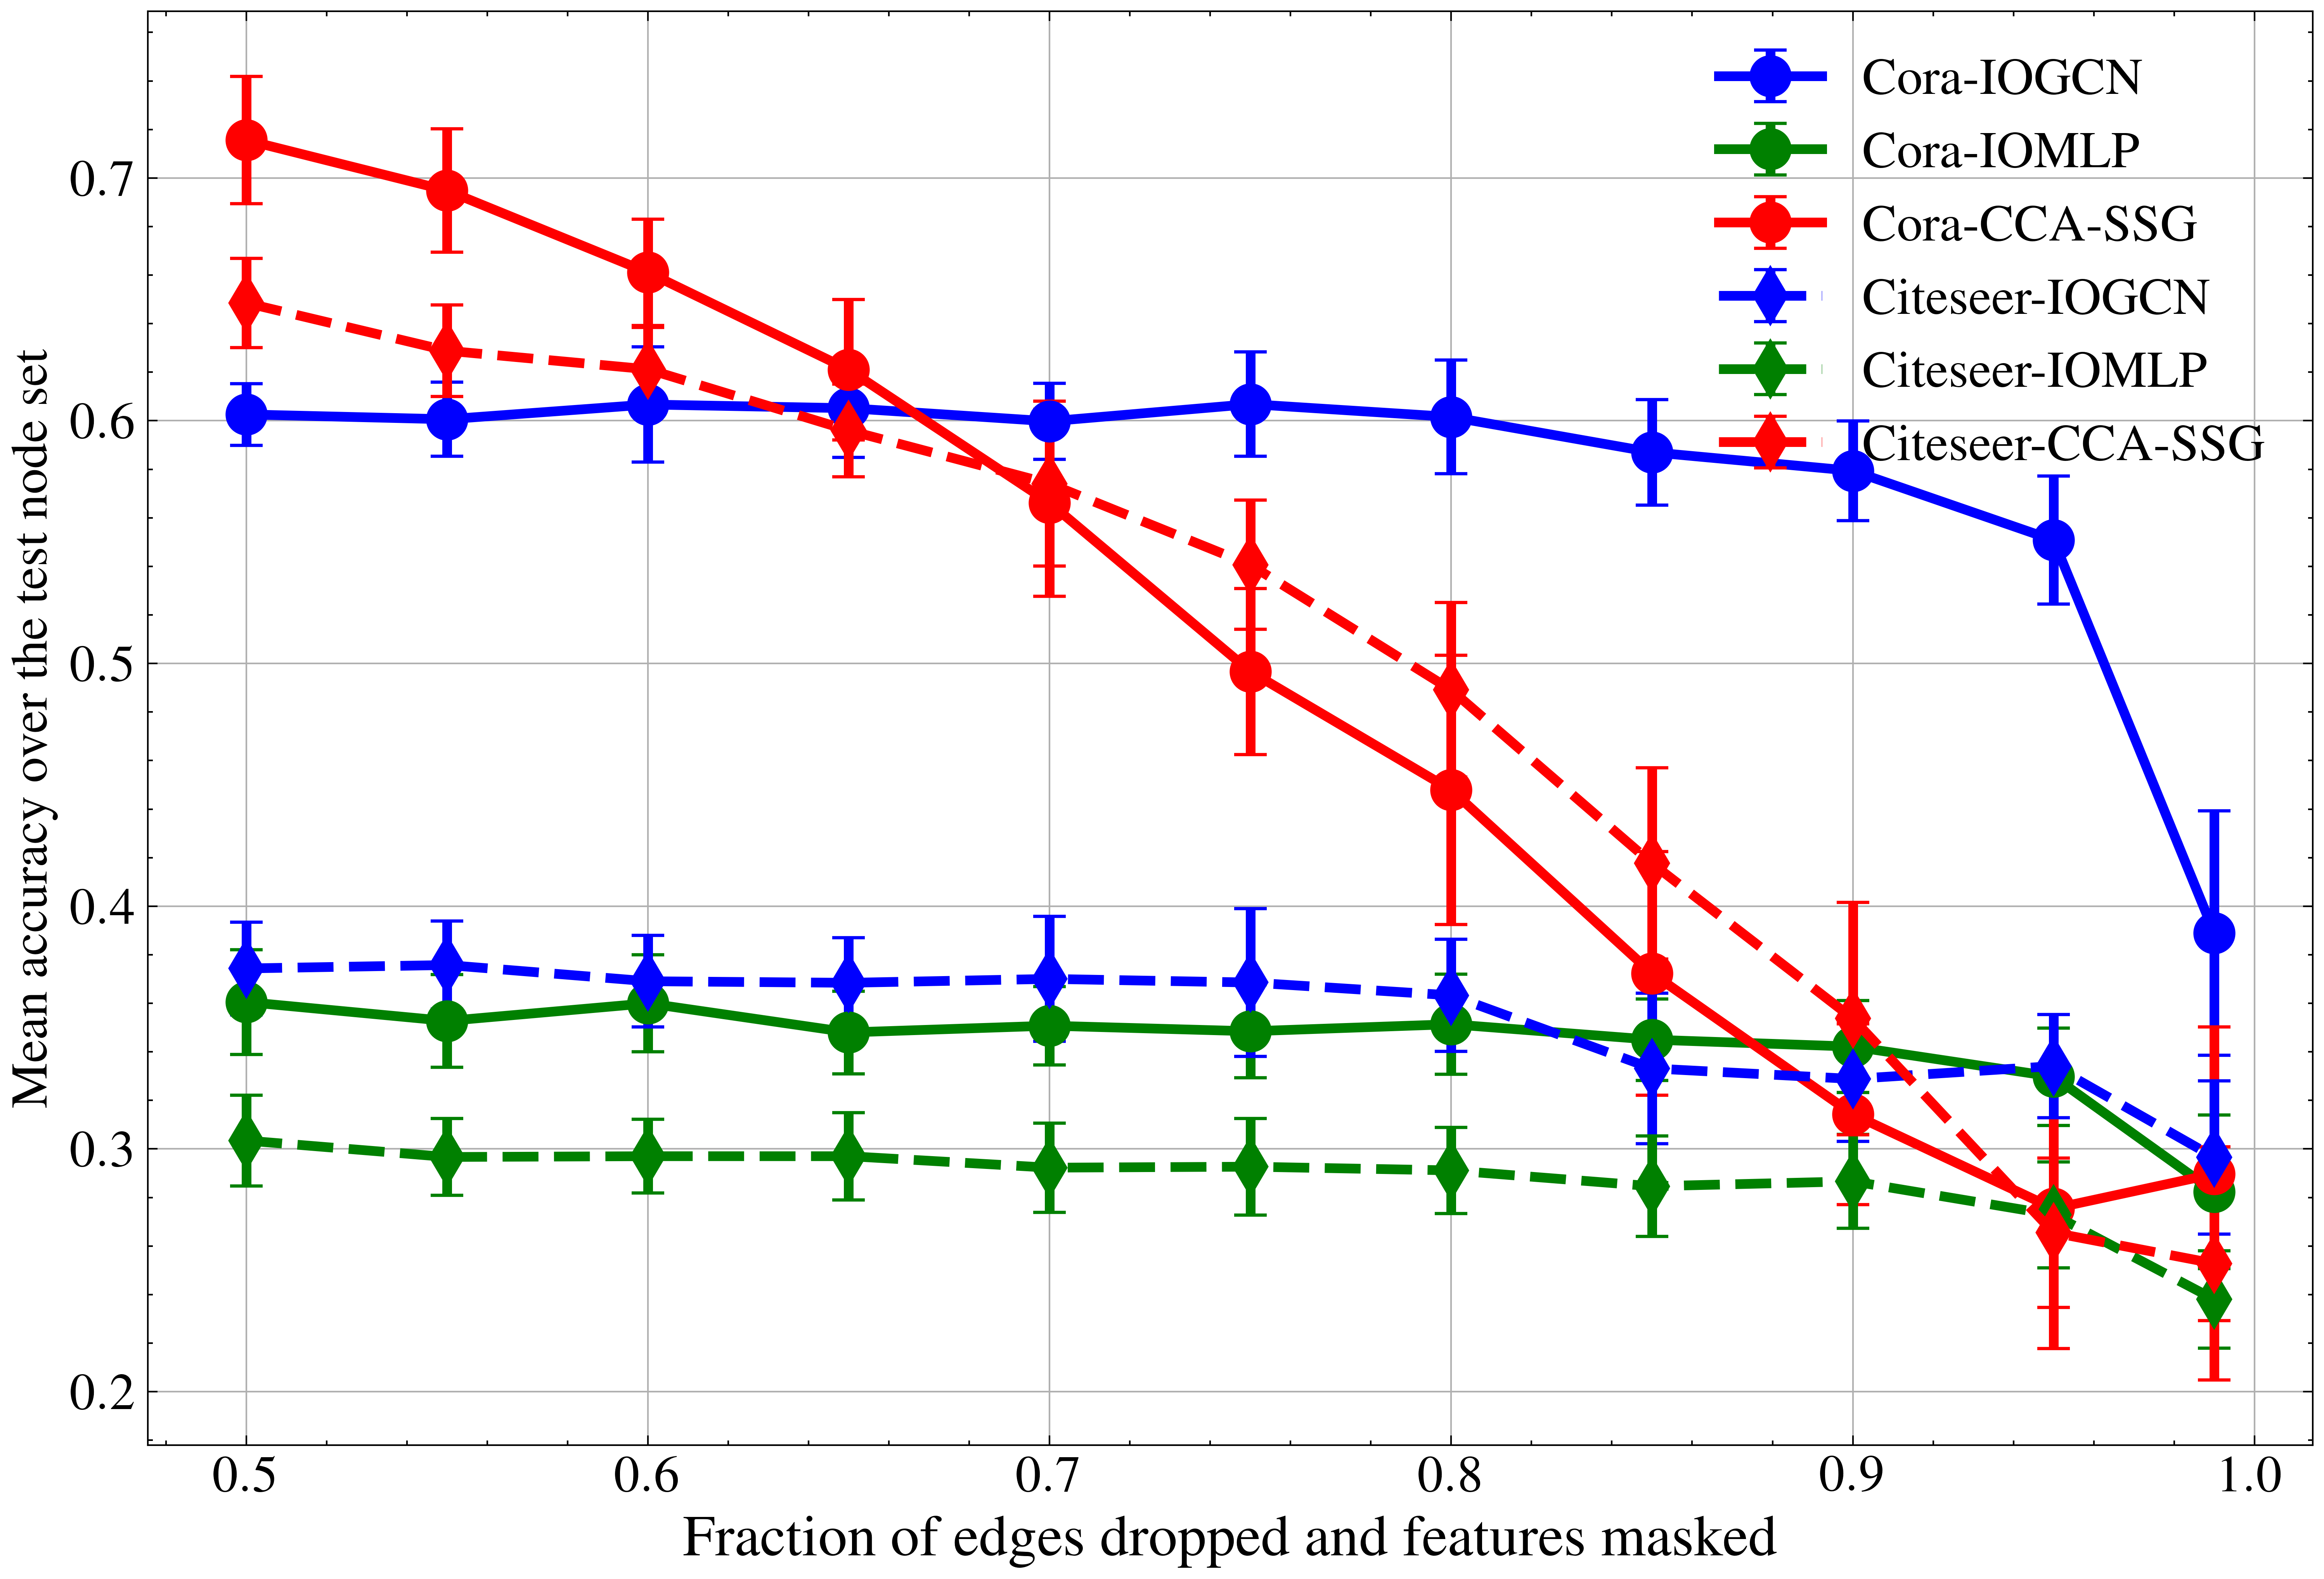

In [14]:
with plt.style.context(['science', 'ieee']):

    plt.figure(figsize=(12,8))

    for d, dataset_name in enumerate(datasets):
        for j, exp in enumerate(EXPS):
            fmt = 'o-' if dataset_name == "cora" else 'd--'
            plt.errorbar(perts, np.mean(eval_accs,3)[d,:,j], yerr=np.std(eval_accs,3)[d,:,j],
                         fmt=fmt, color=exp['color'], linewidth=3, markersize=12, capsize=5,
                         label=dataset_name.capitalize() + '-' + exp['label'])

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.xlabel("Fraction of edges dropped and features masked", fontsize=18)
    plt.ylabel("Mean accuracy over the test node set", fontsize=16)

    plt.legend(fontsize=16)

    plt.grid()

    plt.savefig('ssl_iognn.pdf')

    plt.show()